## Air Quality Forecasting(CO2 emissions)
### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.arima.model import ARIMA


In [2]:
import warnings
warnings.filterwarnings("ignore")

### Time series analysis and transforms

This notebook contains a set of operations we can perform in our time series in order to get some insights or transform the series to make forecasting easier.

Which ones will we touching in this notebook?

* Time series decomposition

  * Level
  * Trend
  * Seasonality
  * Noise
  
* Stationarity

  * AC and PAC plots
  * Rolling mean and std
  * Dickey-Fuller test
  
* Making our time series stationary

  * Difference transform
  * Log scale
  * Smoothing
  * Moving average

### Load the dataset and quick preview

In [3]:
df = pd.read_excel('CO2 dataset.xlsx')

In [4]:
df.head()

,Year,CO2
0,1800.0,0.00568
1,1801.0,0.00561
2,1802.0,0.00555
3,1803.0,0.00548
4,1804.0,0.00542


In [5]:
df.tail()

,Year,CO2
210,2010.0,15.6
211,2011.0,15.6
212,2012.0,14.8
213,2013.0,14.7
214,2014.0,15.1


In [6]:
df.duplicated().sum() # Check for duplicates

0

In [7]:
# Convert year into datetime format
# Set year as index
df.index = pd.to_datetime(df['Year'], format='%Y')
df.drop('Year',axis=1, inplace=True)
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 1800-01-01 to 2014-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     215 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [9]:
df.skew() #Positively skewed

CO2    0.362736
dtype: float64

In [10]:
df.isnull().sum() # Check null values

CO2    0
dtype: int64

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CO2,215.0,6.74197,6.522437,0.00175,0.04105,6.39,11.5,18.2


In [12]:
len(df[df['CO2']<1]) # 37% CO2 values are less then 1

80

In [13]:
df[df['CO2'] == df['CO2'].max()]  # max CO2 emission in 1979

,CO2
Year,
1979-01-01,18.2


Text(0.5, 1.0, 'CO2 Emissions')

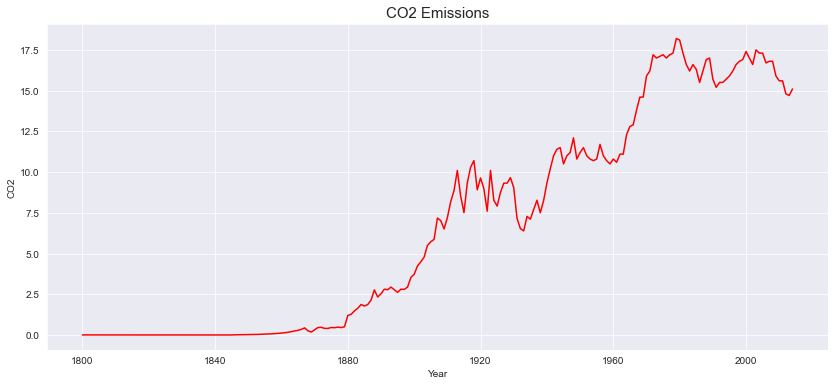

In [14]:
sns.set_style('darkgrid')

plt.figure(figsize=(14,6))
sns.lineplot(data=df["CO2"], color='red')
plt.title('CO2 Emissions', fontsize=15)

<AxesSubplot:xlabel='CO2'>

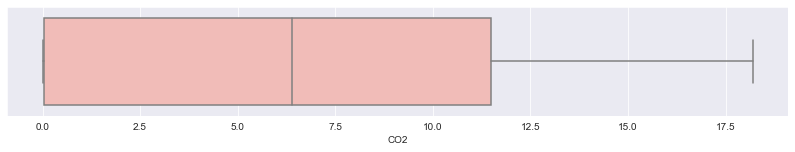

In [15]:
plt.figure(figsize=(14,2))
sns.boxplot(x = df['CO2'], palette='Pastel1')

<AxesSubplot:xlabel='Year'>

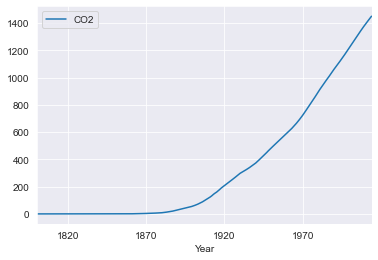

In [16]:
df.cumsum().plot() # rapidly incresing co2 levels 

In [17]:
'''df['percent'] = (df['CO2'] / df['CO2'].sum()) * 100
df['percent'].cumsum().plot() # co2 levels 90% incerese after 1970''' 

"df['percent'] = (df['CO2'] / df['CO2'].sum()) * 100\ndf['percent'].cumsum().plot() # co2 levels 90% incerese after 1970"

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

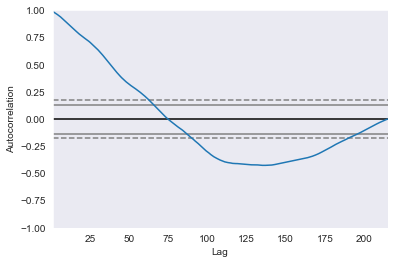

In [18]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['CO2'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

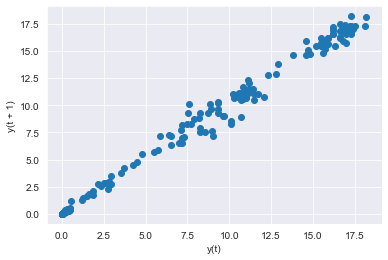

In [19]:
pd.plotting.lag_plot(df) # Lag plot

### Decomposition

One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present (there will be more analysis for this two parts).

This 4 parts can combine either additively or multiplicatively into the time series.

#### Additive Model
y(t) = Level + Trend + Seasonality + Noise

Additives models are linear. Trend is linear and seasonality has constant frequency and amplitude. Change is constant over time

#### Multiplicative model
 y(t) = Level * Trend * Seasonality * Noise

Multiplicatives models are nonlinear, trend is curved and seasonality is not constant. Change is not constant over time

Decomposing is used to analyse the time series. Identify each one of the different parts of the time series and its behaviour, each of the components may affect your models in different ways.

Most time series are a combination of a additive model and a multiplicate model, is hard to identify real world time series into one single model.

#### Automatic time series decomposition
Statsmodel python library provides a function seasonal_decompose() to automatically decompose a time series, you still need to specify wether the model is additive or multiplicative. We will use multiplicative as our quick peak at the time series shows non-linear trend.

#### How to decide our time series is multiplicative or additive?
If the seasonality and residual components are independent of the trend, then you have an additive series. If the seasonality and residual components are in fact dependent, meaning they fluctuate on trend, then you have a multiplicative series

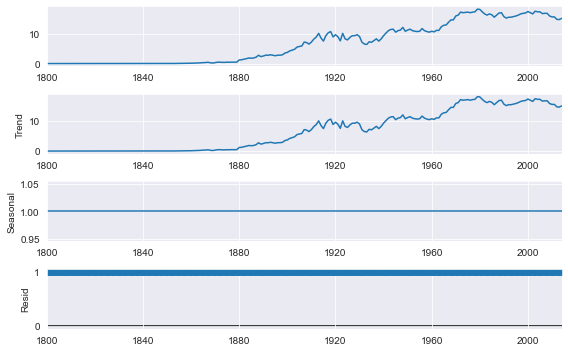

<Figure size 4000x1600 with 0 Axes>

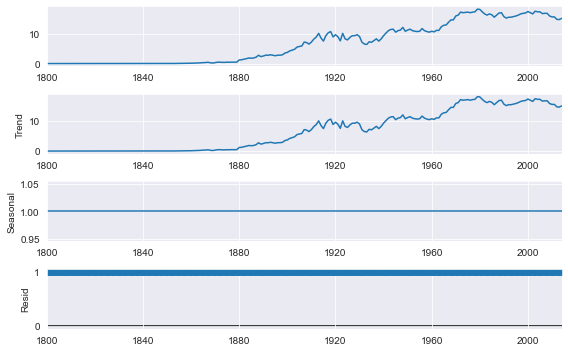

In [20]:
plt.rcParams['figure.figsize'] = 8, 5
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
result = seasonal_decompose(df, model='multiplicative')
result.plot()

#### Seasonal-Trend decomposition using LOESS 

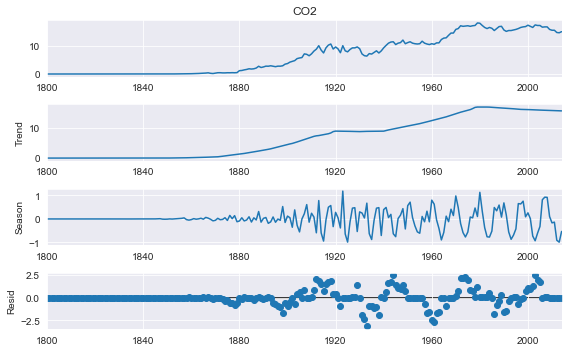

<Figure size 4000x1600 with 0 Axes>

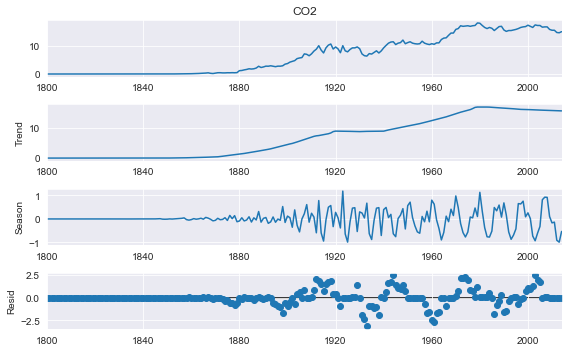

In [21]:
from statsmodels.tsa.seasonal import STL
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')

stl = STL(df.CO2, period=10, robust=True)
res = stl.fit()
res.plot()

### Level
Level simply means the current value of the series once we remove trend, seasonality and the random noise. This are the true values that come from the series itself and we will try to predict with our models. Most of the models will benefit the more our time series is composed by the level and not trends/seasonality/noise. We also present models capable of handling seasonality and trend (non stationary series)

### Trend
A trend is observed when there is an increasing or decreasing slope observed in the time series. A trend is a smooth, general, long-term, average tendency. It is not always necessary that the increase or decrease is in the same direction throughout the given period of time.

Trend can be removed from your time series data (and data in the future) as a data preparation and cleaning exercise. This is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models.

Now we will try some methods to check for trend in our series:

  * Automatic decomposing
  * Moving average
  * Fit a linear regression model to identify trend

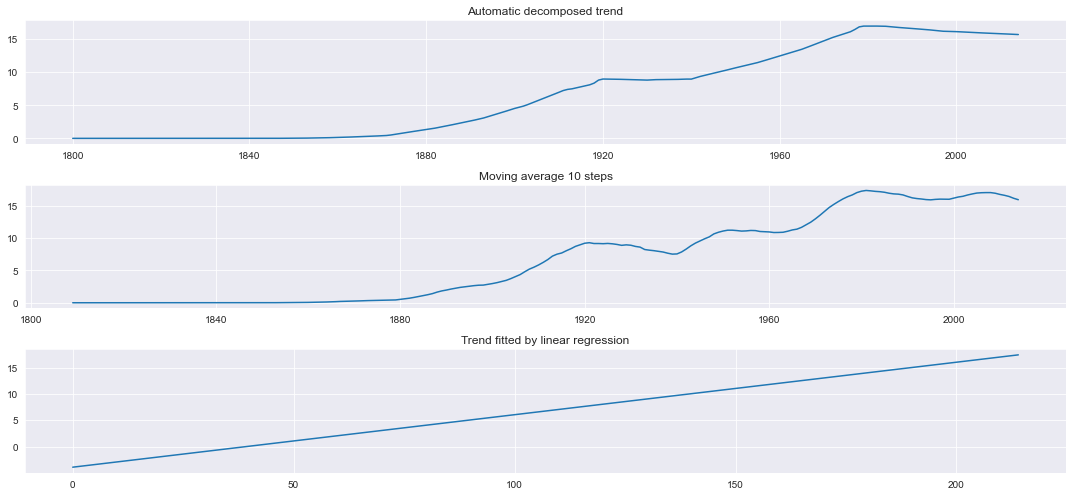

In [22]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(res.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = df.CO2.rolling(10).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 10 steps")


X = [i for i in range(0, len(df.CO2))]
X = np.reshape(X, (len(X), 1))
y = df.CO2.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

We can see our series does not have a strong trend, results from both the automatic decomposition and the moving average look more like a seasonality efect+random noise than a trend. This sort of confirmed with our linear regression, which cant find our series properly and gives us a poor trend.


### Seasonality

Seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day. For example the amount of sunscream protector (always low in winter and high in summer).

The automatic decomposing chart did not gave us a good look into the decomposed seasonality, let's try decomposing smaller parts of the time series first and test seasonalities we found into the others.

<AxesSubplot:xlabel='Year'>

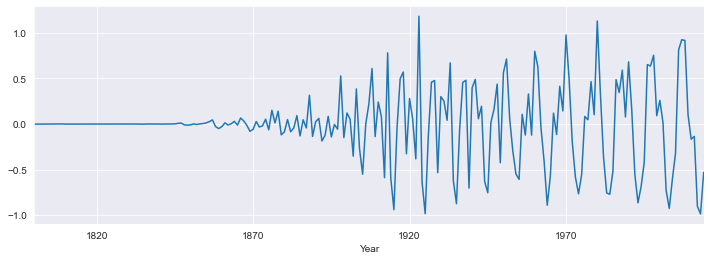

In [23]:
plt.figure(figsize=(12,4))
res.seasonal.plot()

We can see seasonality but a bit different to the original one, this is something we should always expect from real datasets as their seasonalities will never be perfect but a combination of multiples

### Noise
Our time series will also have a noise component to them, most likely white noise. We say white noise is present if the measurement are independent and identically distributed with a mean of zero. This will mean all our measurements have same variance and no correlation with the rest of values in the series.

If our time series has white noise this will mean we can't predict that component of the series (as is random) and we shoul aim to produce a model with errors close to this white noise.

How to check if our series has white noise?

Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std
Correlation plots
Standard deviation distribution, is it a Gaussian distribution?
Does the mean or level change over time?

<AxesSubplot:ylabel='Count'>

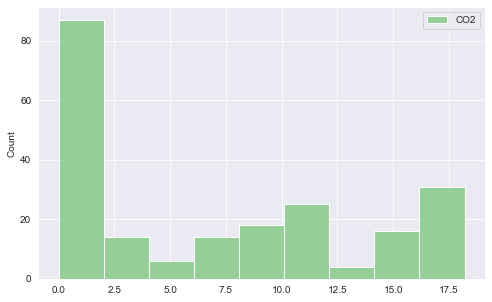

In [24]:
sns.histplot(df, palette='YlGn_r')

<AxesSubplot:ylabel='Density'>

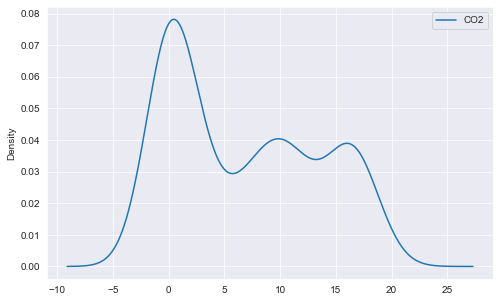

In [25]:
df.plot(kind='kde')

array([[<AxesSubplot:title={'center':'CO2'}>]], dtype=object)

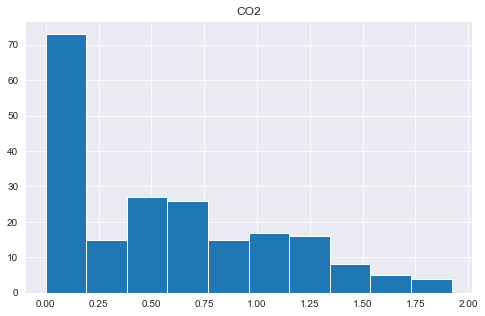

In [26]:
mm = df.rolling(10).std()
mm.hist()

We can see our series do not follow a Gaussian distribution from the histogram and neither the standard deviation, thought the std does has the mean more centered which shows a small part of white noise that is not possible to split from the original series (this will happen most of the times, specially is real life datasets).

### Stationarity
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

#### Check for sationarity
##### Autocorrelation and Partial autocorrelation plots
Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.

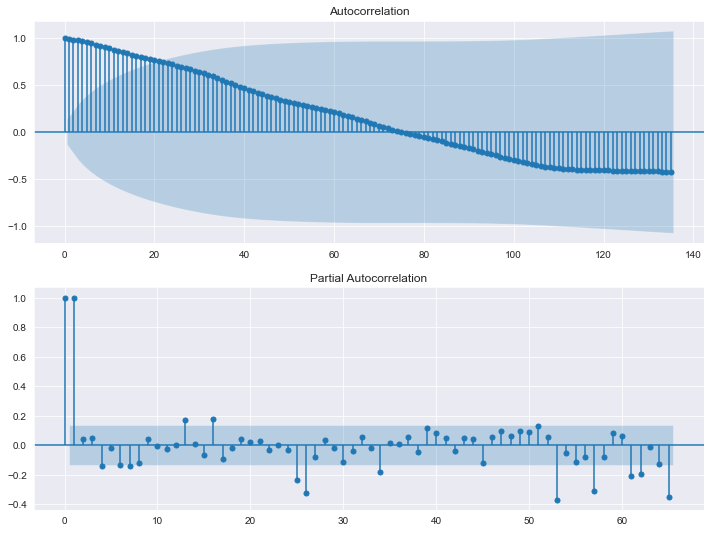

In [27]:
# Autocorrelation and partial auto correlation
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['CO2'],lags=135,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['CO2'],lags=65,ax=ax2, method='yw')

### Smoothing Techniques

* Simple Moving Average
* Exponantional Moving Average
* Simple Exponential Smoothin
* Double Exponential Smoothing
* Holt's Exponential Smoothing

In [28]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

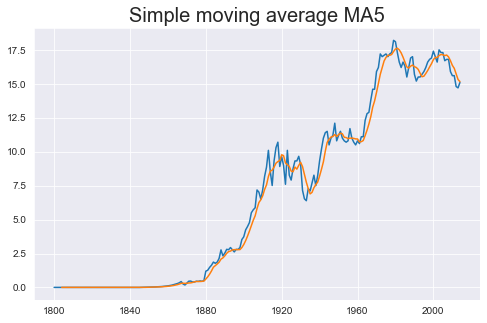

In [29]:
df['MA5'] = df['CO2'].rolling(window=5).mean()

# Plot
plt.title('Simple moving average MA5', size=20)
plt.plot(df['CO2'], label='Original')
plt.plot(df['MA5'], label='MA5')

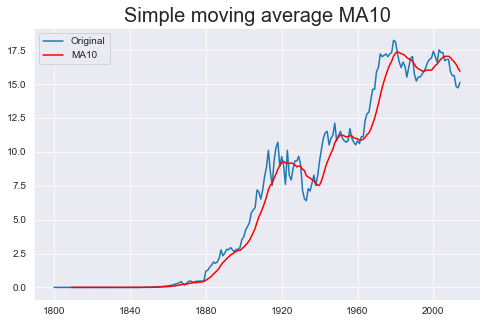

In [30]:
df['MA10'] = df['CO2'].rolling(window=10).mean()

# Plot
plt.title('Simple moving average MA10', size=20)
plt.plot(df['CO2'], label='Original')
plt.plot(df['MA10'], color='red', label='MA10')
plt.legend(); 

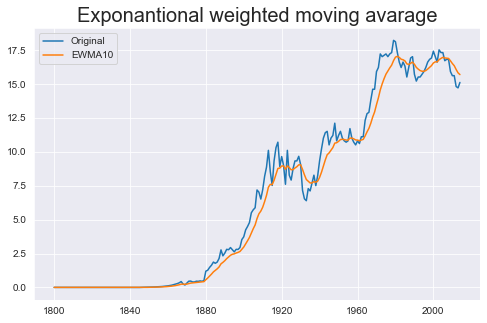

In [31]:
### Exponantional weighted moving avarage(EWMA)

df['EWMA10']=df['CO2'].ewm(span=10,adjust=True).mean()

plt.title('Exponantional weighted moving avarage', size=20)
plt.plot(df['CO2'], label='Original')
plt.plot(df['EWMA10'], label='EWMA10')
plt.legend();

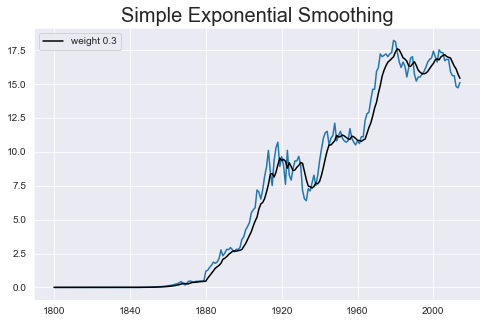

In [32]:
# Simple Exponential Smoothing

fit1 = SimpleExpSmoothing(df.CO2).fit(smoothing_level=0.3, optimized=False)

plt.title('Simple Exponential Smoothing', size=20)
plt.plot(df.CO2)
plt.plot(fit1.fittedvalues, color='black', label = 'weight 0.3')
plt.legend();

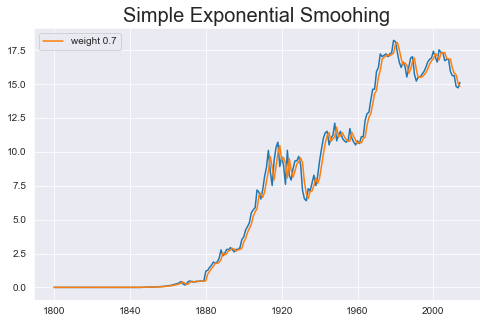

In [33]:
fit2 = SimpleExpSmoothing(df.CO2).fit(smoothing_level=0.7, optimized=False)

plt.title('Simple Exponential Smoohing', size=20)
plt.plot(df.CO2)
plt.plot(fit2.fittedvalues, label = 'weight 0.7')
plt.legend();

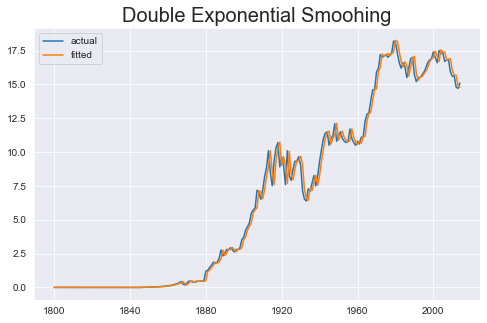

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
doublexp = ExponentialSmoothing(df.CO2, trend='mul').fit()

plt.title('Double Exponential Smoohing', size=20)
plt.plot(df.CO2, label = 'actual')
plt.plot(doublexp.fittedvalues, label = 'fitted')
plt.legend()

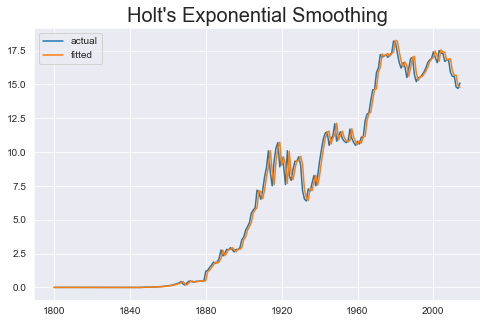

In [35]:
holtfit2 = Holt(df.CO2, exponential=True).fit() # Linear trend

plt.title("Holt's Exponential Smoothing", size=20)
plt.plot(df.CO2, label = 'actual')
plt.plot(holtfit2.fittedvalues, label = 'fitted')
plt.legend();

### Augmented Dickey-Fuller test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. 
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [36]:
adfuller(df.CO2) 
# failed to reject Null Hypothesis (HO): Series is non-stationary or series has a unit root.

(-0.3784627751558869,
 0.9136330950336237,
 0,
 214,
 {'1%': -3.4612821203214907,
  '5%': -2.875142613826617,
  '10%': -2.574020122281422},
 342.9453091768805)

In [37]:
kpss(df.CO2)
# Failed to reject Alternate Hypothesis(HA): Series is non-stationary or series has a unit root.

(1.3577252438593592,
 0.01,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

#### Making Time Series Stationary

### Differencing
a method of transforming a time series 

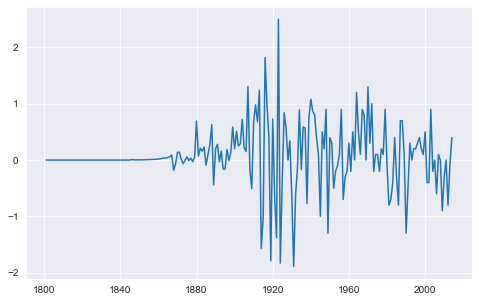

In [38]:
# making the data stationary
df['First Difference'] = df['CO2'] - df['CO2'].shift(1)
plt.plot(df['First Difference'])

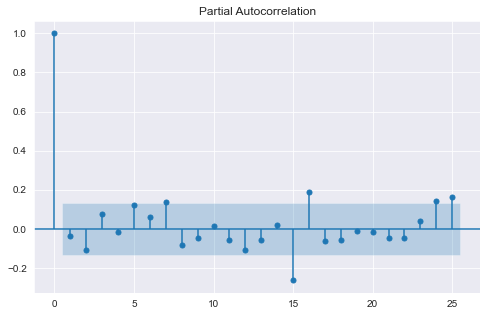

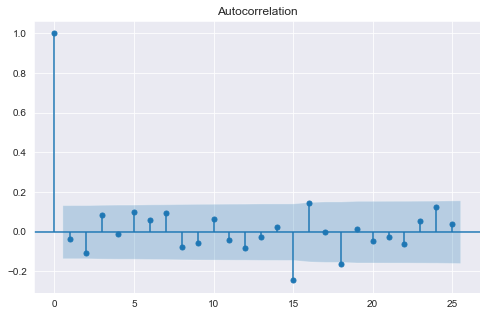

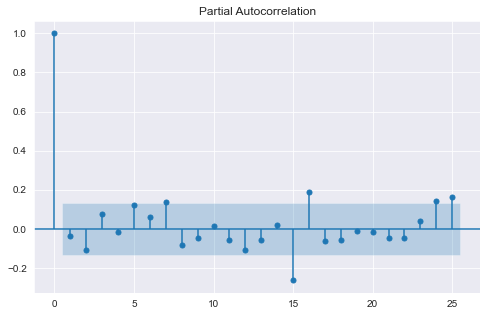

In [40]:
# Acf and Pacf of differenced time series
plot_acf(df['First Difference'].dropna(),lags=25)
plot_pacf(df['First Difference'].dropna(),lags=25)

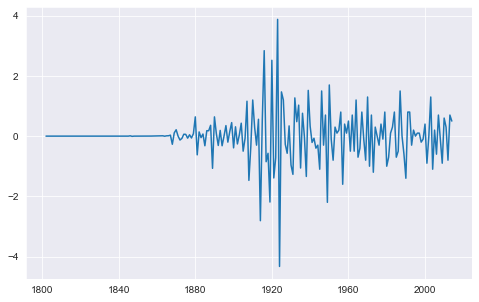

In [41]:
# Second order differencing
df['Second order'] = df['CO2'] - 2*df['CO2'].shift(1) + df['CO2'].shift(2)
plt.plot(df['Second order'])

In [42]:
# Chech stationarity on first lag difference
adfuller(df['First Difference'].dropna()) # HA: Series is stationary

(-3.7800045305842556,
 0.003118649594241994,
 15,
 198,
 {'1%': -3.4638151713286316,
  '5%': -2.876250632135043,
  '10%': -2.574611347821651},
 337.0674484072087)

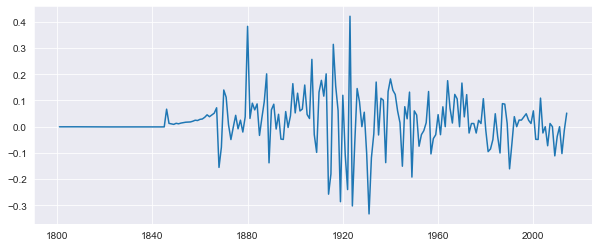

In [43]:
# transformation differencing
plt.figure(figsize=(10,4))
plt.plot(np.sqrt(df.CO2).diff())

### Analysis by dividing the data into 5 equal parts

<AxesSubplot:xlabel='Year', ylabel='CO2'>

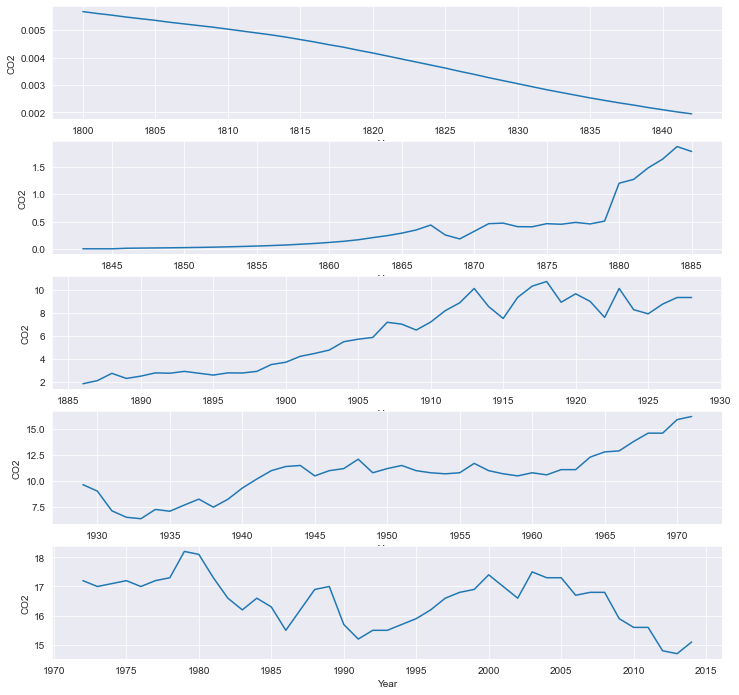

In [44]:
a,b,c,d,f = np.array_split(df, 5) # divide the dataset into 5 equal parts 
plt.figure(figsize=(12,12))
plt.subplot(511)
sns.lineplot(data=a['CO2'])

plt.subplot(512)
sns.lineplot(data=b['CO2'])

plt.subplot(513)
sns.lineplot(data=c['CO2'])

plt.subplot(514)
sns.lineplot(data=d['CO2'])

plt.subplot(515)
sns.lineplot(data=f['CO2'])

we can see in the very begining the values are decrising and then continuesly incresing over the time. in last few years we can see sligh drop in co2 levels.

### Transformations

* Log  transformation
* Square root ->  (√x) 
* Reciprocal transformation 
* Log ->  log(x) 
* Power transformations

#### Log  transformation
Applying a log transform to a time series could also help remove the series dependence on time.

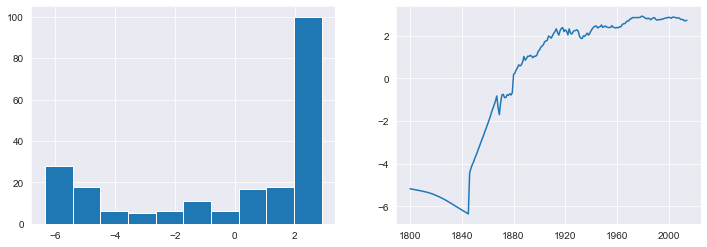

In [45]:
# LOG Transformation

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(np.log(df.CO2)) # log transformation
plt.subplot(122)
plt.plot(np.log(df.CO2))

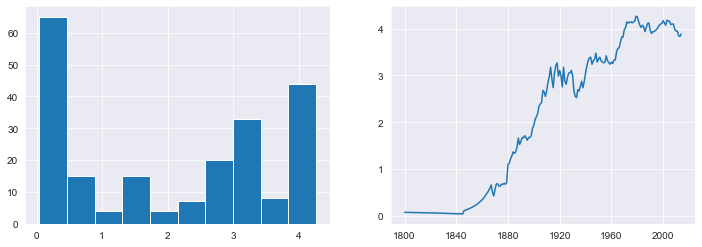

In [46]:
# SQRT Transformation 

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(np.sqrt(df.CO2))
plt.subplot(122)
plt.plot(np.sqrt(df.CO2))

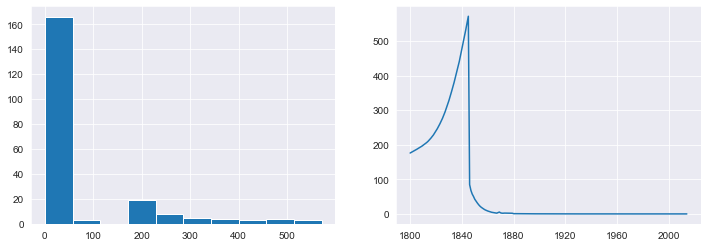

In [47]:
# Reciprocal Transformation 

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(np.reciprocal(df.CO2))
plt.subplot(122)
plt.plot(np.reciprocal(df.CO2))

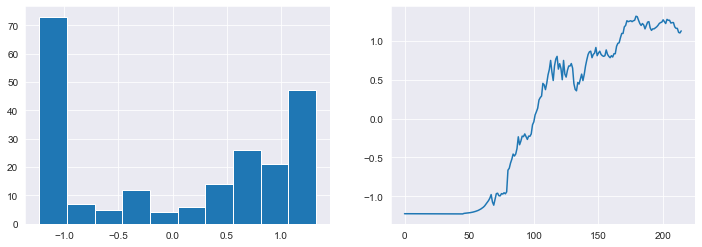

In [48]:
# Power Transformation
from sklearn.preprocessing import power_transform
af = df['CO2'].values.reshape(-1, 1)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(power_transform(af))
plt.subplot(122)
plt.plot(power_transform(af))

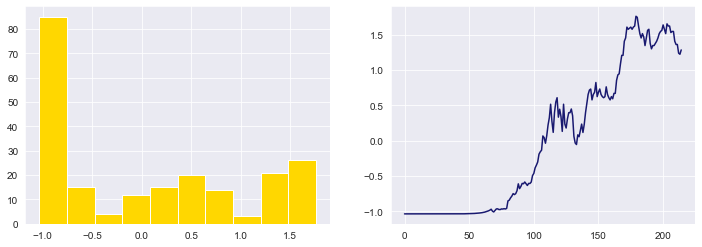

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(af)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(scaled, color='gold')
plt.subplot(122)
plt.plot(scaled, color='midnightblue')

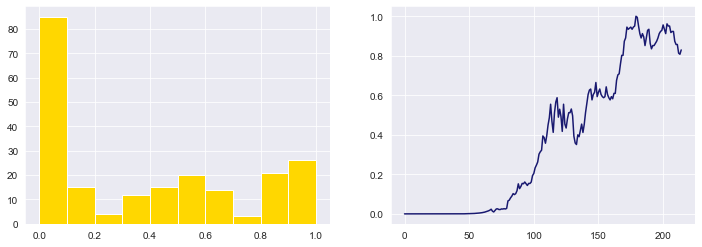

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_1 = scaler.fit_transform(af)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(scaled_1, color='gold')
plt.subplot(122)
plt.plot(scaled_1, color='midnightblue')

##### Removing some values which is near to 0

In [51]:
new_df = df[df.CO2>0.5]

<AxesSubplot:xlabel='Year'>

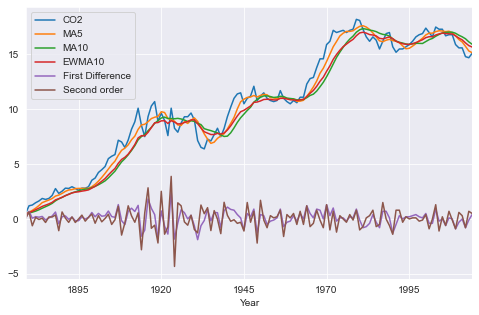

In [52]:
new_df.plot()

### Train Test Split

In [53]:
train_data = df.loc[:'2000-01-01','CO2']
test_data = df.loc['2000-01-01':]

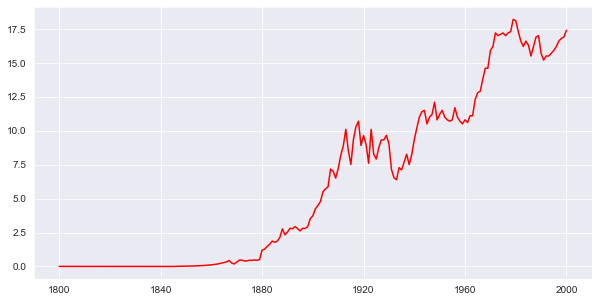

In [54]:
plt.figure(figsize=(10,5))
plt.plot(train_data, color='red')

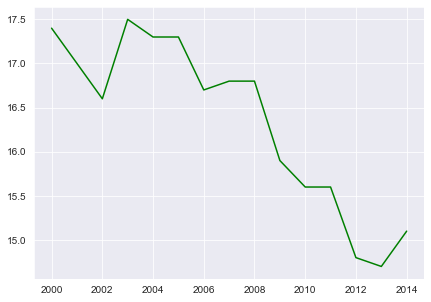

In [55]:
plt.figure(figsize=(7,5))
plt.plot(test_data['CO2'], color = 'green')

### Data Driven Models

In [56]:
from statsmodels.tsa.ar_model import AutoReg


# Instantiate and fit the AR model with training data
ar_model = AutoReg(train_data, lags=15).fit()

# Print Summary
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                  201
Model:                    AutoReg(15)   Log Likelihood                -151.135
Method:               Conditional MLE   S.D. of innovations              0.545
Date:                Mon, 27 Dec 2021   AIC                             -1.030
Time:                        12:20:22   BIC                             -0.735
Sample:                    01-01-1815   HQIC                            -0.911
                         - 01-01-2000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0844      0.059      1.440      0.150      -0.030       0.199
CO2.L1         0.9461      0.073     12.885      0.000       0.802       1.090
CO2.L2        -0.0682      0.101     -0.675      0.4

RMSE: 2.899389539127096
MAE: 2.4944883862327454


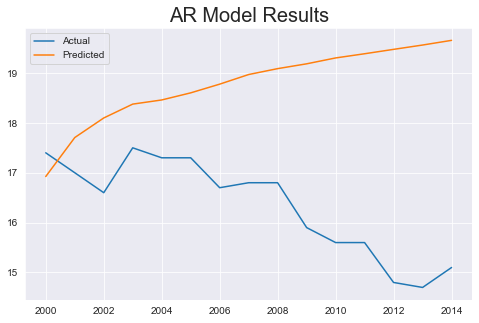

In [57]:
ar_forecast = ar_model.predict('2000-01-01', '2014-01-01')

plt.title('AR Model Results', size=20)
plt.plot(df.loc['2000-01-01':,'CO2'],label='Actual')
plt.plot(ar_forecast,label='Predicted')
plt.legend();

print('RMSE:', np.sqrt(mean_squared_error(df.loc['2000-01-01':,'CO2'],ar_forecast)))
print('MAE:', mean_absolute_error(df.loc['2000-01-01':,'CO2'],ar_forecast))

RMSE: 0.577882181572858
MAE: 0.4887965066595153


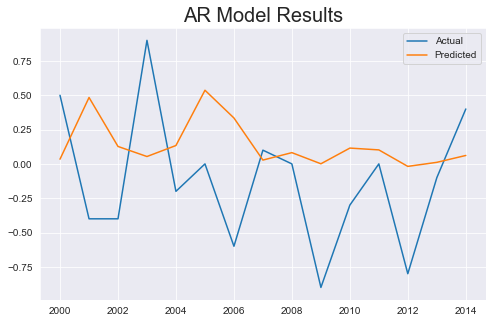

In [58]:
train_datafd = df.loc['1801-01-01':'2000-01-01','First Difference']

# Instantiate and fit the AR model with training data
ar_modelfd = AutoReg(train_datafd, lags=15).fit()

# Print Summary
#print(ar_modelfd.summary())

ar_forecastfd = ar_modelfd.predict('2000-01-01', '2014-01-01')
plt.title('AR Model Results', size=20)
plt.plot(df.loc['2000-01-01':,'First Difference'],label='Actual')
plt.plot(ar_forecastfd,label='Predicted')
plt.legend();

print('RMSE:',np.sqrt(mean_squared_error(df.loc['2000-01-01':,'First Difference'],ar_forecastfd)))
print('MAE:',mean_absolute_error(df.loc['2000-01-01':,'First Difference'],ar_forecastfd))

### ARIMA

##### Model 1

In [59]:
arima = ARIMA(train_data, order=(0, 2 ,0))
results = arima.fit()
predictions = results.predict('2000-01-01', '2014-01-01')

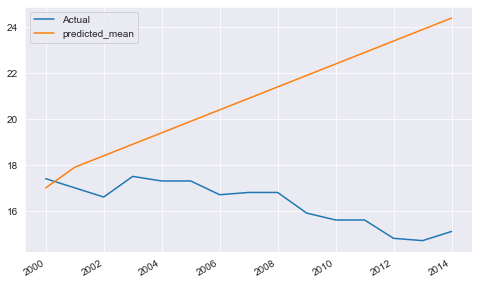

In [60]:
plt.plot(df.loc['2000-01-01':,'CO2'],label='Actual')
predictions.plot()
plt.legend();

In [61]:
print('RMSE',np.sqrt(mean_squared_error(df.loc['2000-01-01':,'CO2'],predictions)))
print('MAE',mean_absolute_error(df.loc['2000-01-01':,'CO2'],predictions))

RMSE 5.474912480274607
MAE 4.586666666666664


##### Model 2

RMSE: 0.49510491370897197
MAE 0.4410041279908461


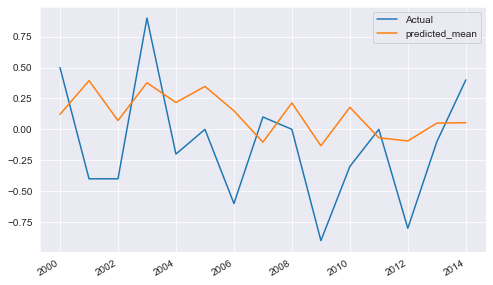

In [62]:
from statsmodels.tsa.arima.model import ARIMA

arima2 = ARIMA(df.loc[:,'First Difference'], order=(15, 1, 2))
results2 = arima2.fit()
predictions2 = results2.predict('2000-01-01', '2014-01-01')

plt.plot(df.loc['2000-01-01':,'First Difference'],label='Actual')
predictions2.plot()
plt.legend();

print('RMSE:',np.sqrt(mean_squared_error(df.loc['2000-01-01':,'First Difference'],predictions2)))
print('MAE',mean_absolute_error(df.loc['2000-01-01':,'First Difference'],predictions2))

<AxesSubplot:>

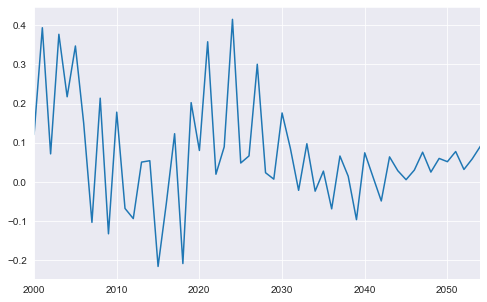

In [63]:
import pickle
with open('arimafoo.pkl', 'wb') as pkl:
    pickle.dump(results2, pkl)
    
with open('arimafoo.pkl', 'rb') as pkl:
    pickle_preds = pickle.load(pkl)
    
start = '2000-01-01'
end = '2054-01-01'
pickle_preds.predict(start, end).plot()

##### Model 3

In [46]:
arima3 = ARIMA(df.loc['1803-01-01':'2000-01-01','Second order'], order=(2, 2, 8))
results3 = arima3.fit()
predictions33 = results3.predict('2000-01-01', '2014-01-01')

RMSE: 0.6225600204055299
MAE: 0.5378185674315116


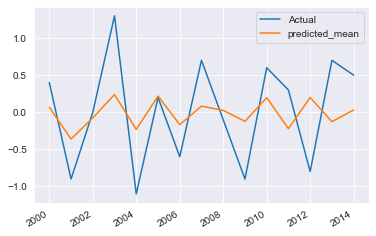

In [47]:
plt.plot(df.loc['2000-01-01':,'Second order'],label='Actual')
predictions33.plot()
plt.legend();

print('RMSE:',np.sqrt(mean_squared_error(df.loc['2000-01-01':,'Second order'],predictions33)))
print('MAE:', mean_absolute_error(df.loc['2000-01-01':,'Second order'],predictions33))

##### Model 4

In [149]:
arima4 = ARIMA(df.loc[:'2000-01-01','Second order'], order=(4, 1, 0))
results4 = arima4.fit()
predictions4 = results4.predict('2000-01-01', '2014-01-01')

RMSE: 0.6784532986001434
MAE: 0.5804774910213752


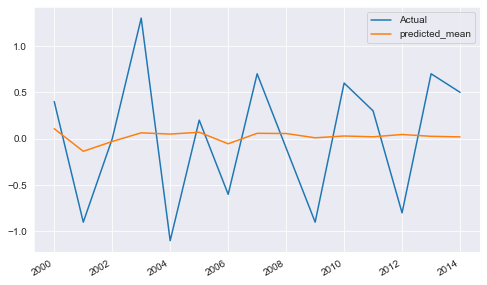

In [150]:
plt.plot(df.loc['2000-01-01':,'Second order'],label='Actual')
predictions4.plot()
plt.legend();

print('RMSE:', np.sqrt(mean_squared_error(df.loc['2000-01-01':,'Second order'],predictions4)))
print('MAE:', mean_absolute_error(df.loc['2000-01-01':,'Second order'],predictions4))

### Auto ARIMA

In [294]:
import pmdarima as pm

In [295]:
autoModel = pm.auto_arima(train_data, trace=True,max_p=10, max_d=2, max_q=3,error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=335.403, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=332.305, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=333.980, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=333.891, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=335.248, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=334.705, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.678 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [312]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(df.CO2, start_p=1, start_q=1,
                           max_p=5, max_q=4, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=355.595, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=353.513, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=355.231, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=355.157, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=355.035, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.268 seconds
353.5128252350575


In [300]:
stepwise_model.fit(train.CO2)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

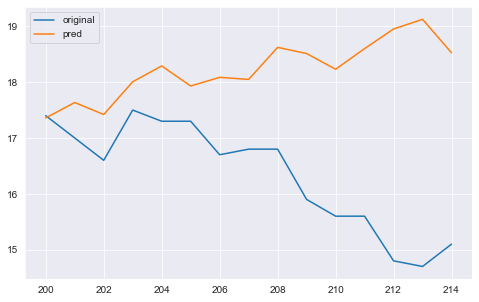

In [310]:
test['future_forecast'] = stepwise_model.predict(15)
plt.plot(test.CO2, label='original')
plt.plot(test['future_forecast'], label='pred')
plt.legend();

### TBATS


In [151]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model = estimator.fit(train_data)

# Forecast 365 days ahead

In [152]:
y_forecast = model.forecast(10)

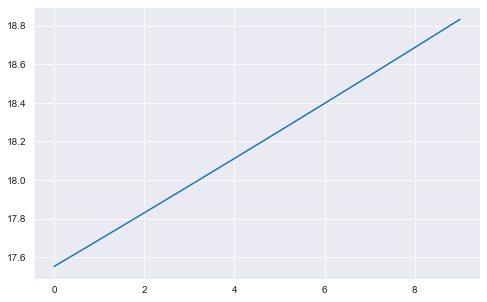

In [153]:
plt.plot(y_forecast)

### Simple Linear Model


In [20]:
df['t'] = range(1,216)
df['t_square'] = df['t']**2
df.reset_index(inplace=True)

In [21]:
train = df.head(200)
test = df.tail(15)

RMSE: 1.4378779595679616
MAE: 1.1403177593479845


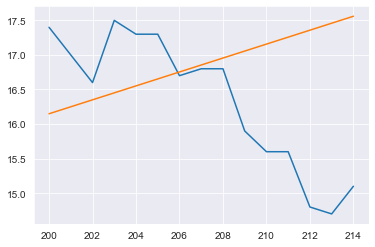

In [22]:
import statsmodels.formula.api as smf 
from sklearn.metrics import mean_absolute_percentage_error

linear_model = smf.ols('CO2~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))

plt.plot(test.CO2)
plt.plot(pred_linear)

print('RMSE:', np.sqrt(mean_squared_error(test.CO2,pred_linear)))
print('MAE:', mean_absolute_error(test.CO2,pred_linear))

### Simple Exponential Method


RMSE: 0.9403040003421604
MAE: 0.8411463070561953


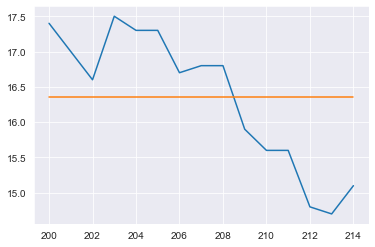

In [29]:
ses_model = SimpleExpSmoothing(train["CO2"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])

plt.plot(test.CO2)
plt.plot(pred_ses)

print('RMSE:', np.sqrt(mean_squared_error(test.CO2,pred_ses)))
print('MAE:', mean_absolute_error(test.CO2,pred_ses))

### Holt method 


RMSE: 2.2841146684762053
MAE: 1.7579330878827946


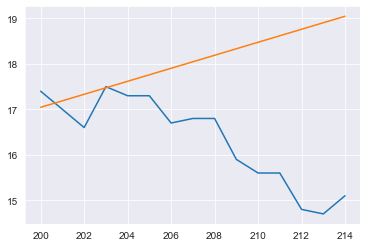

In [30]:
hw_model = Holt(train["CO2"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])

plt.plot(test.CO2)
plt.plot(pred_hw)

print('RMSE:', np.sqrt(mean_squared_error(test.CO2,pred_hw)))
print('MAE:', mean_absolute_error(test.CO2,pred_hw))

### Holts winter exponential smoothing with additive seasonality and additive trend


RMSE: 1.7988138213604528
MAE: 1.3518367289370006


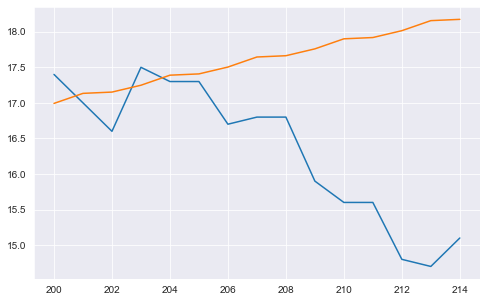

In [242]:
hwe_model_add_add = ExponentialSmoothing(train["CO2"],seasonal="add",trend="add",seasonal_periods=3).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])

plt.plot(test.CO2)
plt.plot(pred_hwe_add_add)

print('RMSE:', np.sqrt(mean_squared_error(test.CO2,pred_hwe_add_add)))
print('MAE:', mean_absolute_error(test.CO2,pred_hwe_add_add))

### Quadratic method


RMSE: 4.902995859368441
MAE: 4.567318830457547


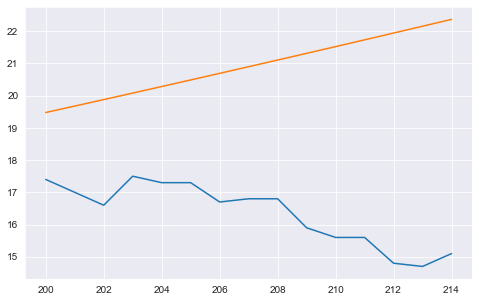

In [243]:
Quad = smf.ols('CO2~t+t_square',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_square"]]))

plt.plot(test.CO2)
plt.plot(pred_Quad)

print('RMSE:', np.sqrt(mean_squared_error(test.CO2,pred_Quad)))
print('MAE:', mean_absolute_error(test.CO2,pred_Quad))

### Ridge and Lasso method

RMSE: 1.4378715675817813
MAE: 1.140313965417573


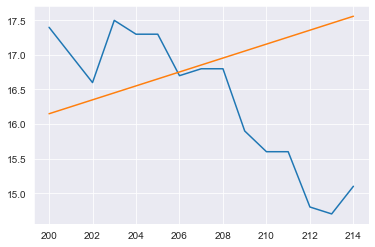

In [24]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge()
ridge.fit(np.array(train['t']).reshape(-1, 1), train.CO2)

test['ridgecv_pred'] = ridge.predict(np.array(test['t']).reshape(-1, 1))

plt.plot(test.CO2)
plt.plot(test['ridgecv_pred'])

print('RMSE:', np.sqrt(mean_squared_error(test.CO2,test.ridgecv_pred)))
print('MAE:', mean_absolute_error(test.CO2,test.ridgecv_pred))

RMSE: 1.4254999894234845
MAE: 1.132787571093277


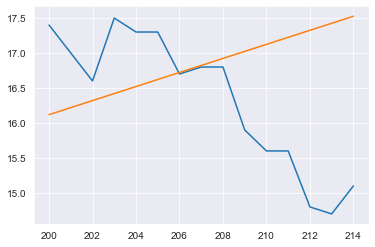

In [25]:
lasso = Lasso()
lasso.fit(np.array(train['t']).reshape(-1, 1), train.CO2)

test['lasso_pred'] = lasso.predict(np.array(test['t']).reshape(-1, 1))

plt.plot(test.CO2)
plt.plot(test['lasso_pred'])

print('RMSE:', np.sqrt(mean_squared_error(test.CO2,test.lasso_pred)))
print('MAE:', mean_absolute_error(test.CO2,test.lasso_pred))

### XGboost & Litgbm

RMSE: 0.9596439268597984
MAE: 0.8067674763997398


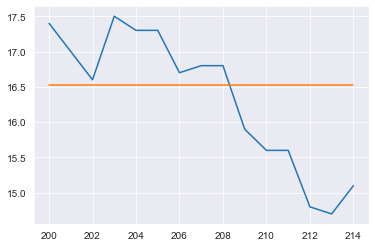

In [26]:
from xgboost import XGBRegressor 

xgb = XGBRegressor(alpha = 0.7)
xgb.fit(np.array(train['t']).reshape(-1, 1), train.CO2)

test['xgb_pred'] = xgb.predict(np.array(test['t']).reshape(-1, 1))

plt.plot(test.CO2)
plt.plot(test['xgb_pred'])

print('RMSE:', np.sqrt(mean_squared_error(test.CO2,test.xgb_pred)))
print('MAE:', mean_absolute_error(test.CO2,test.xgb_pred))

RMSE: 0.9411165871908612
MAE: 0.8364629390863103


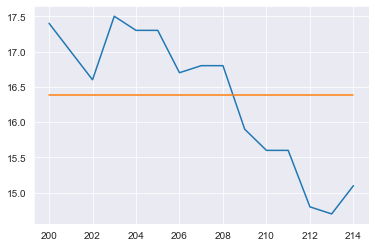

In [27]:
from lightgbm import LGBMRegressor 

lgb = LGBMRegressor()
lgb.fit(np.array(train['t']).reshape(-1, 1), train.CO2)

test['lgb_pred'] = lgb.predict(np.array(test['t']).reshape(-1, 1))

plt.plot(test.CO2)
plt.plot(test['lgb_pred'])

print('RMSE:', np.sqrt(mean_squared_error(test.CO2,test['lgb_pred'])))
print('MAE:', mean_absolute_error(test.CO2,test['lgb_pred']))

Thank you!